In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter, OrderedDict
from nltk.corpus import stopwords
from sklearn.cross_validation import train_test_split
import re

from automation_mapping import *
from automating_tech_helpers import *
from machines_helpers import *
from ai_tech_helpers import *

%matplotlib inline

# LOAD DATA

In [2]:
unspsc = pd.read_table('../data/onet_tools_technology/UNSPSC Reference.txt') # occupation code database
tt6 = pd.read_csv('../data/db06/Tools_and_Technology.csv') # tools & tech 2006
tt9 = pd.read_csv('../data/db09/Tools and Technology.csv') # tools & tech 2009
tt15 = pd.read_table('../data/db15/Tools and Technology.txt') # tools & tech 2015
occ_ref = pd.read_csv('../data/db15/helpers/occ_codes/occupation_reference.csv')
class_codes = pd.read_csv('../data/db15/helpers/tech_codes/class_codes.csv')
family_codes = pd.read_csv('../data/db15/helpers/tech_codes/family_codes.csv')
segment_codes = pd.read_csv('../data/db15/helpers/tech_codes/segment_codes.csv')

tt15 = pd.merge(tt15, occ_ref, how = 'left', on = ['O*NET-SOC Code']) ## add occupation titles to tt15
tt9 = pd.merge(tt9, occ_ref, how = 'left', on = ['O*NET-SOC Code']) ## add occupation titles to tt15
tt6 = pd.merge(tt6, occ_ref, how = 'left', on = ['O*NET-SOC Code']) ## add occupation titles to tt15

# CLEAN DATA

In [3]:
def remove_punc_stopwords_lower(s):
    stop = stopwords.words('english')
    regex = r"\W+"
    return " ".join([i for i in re.split(regex, s.lower()) if i not in stop])

def fix_titles(df):
    new_df = df.copy()
    new_df['T2 Example'] = new_df['T2 Example'].apply(lambda x: remove_punc_stopwords_lower(x))
    new_df['Commodity Title'] = new_df['Commodity Title'].apply(lambda x: remove_punc_stopwords_lower(x))
    return new_df

def add_tech_groupings(df):
    new_df = df.copy()
    new_df['segment_code'] = create_codes(new_df, group = 'Segment')
    new_df['class_code'] = create_codes(new_df, group = 'Class')
    new_df['family_code'] = create_codes(new_df, group = 'Family')
    return new_df

def add_group_titles(df, class_codes, family_codes, segment_codes):
    new_df = df.copy()
    add_class = new_df.merge(class_codes, how = 'left', on = 'class_code')
    add_family = add_class.merge(family_codes, how = 'left', on = 'family_code')
    final = add_family.merge(segment_codes, how = 'left', on = 'segment_code')
    return final

def full_clean(df, class_codes, family_codes, segment_codes):
    new_df = df.copy()
    new_df = add_tech_groupings(fix_titles(new_df))
    new_df = add_group_titles(new_df, class_codes, family_codes, segment_codes)
    return new_df
    
tt6 = full_clean(tt6, class_codes, family_codes, segment_codes)
tt9 = full_clean(tt9, class_codes, family_codes, segment_codes)
tt15 = full_clean(tt15, class_codes, family_codes, segment_codes)

> ### Note – saved in /code/helpers as clean_tt_df.py

# EMERGING TECHNOLOGIES

In [78]:
tech6 = set(tt6['Commodity Code'])
tech9 = set(tt9['Commodity Code'])
tech15 = set(tt15['Commodity Code'])
emerged_codes = tech15 - tech9

tt9_titles = set(tt9['T2 Example'])
tt15_titles = set(tt15['T2 Example'])
emerged_titles = tt15_titles - tt9_titles

adoptions = tt15[tt15['Commodity Code'].isin(emerged_codes) & tt15['T2 Example'].isin(emerged_titles)]
len(adoptions['O*NET-SOC Code'].unique())/float(len(tt15['O*NET-SOC Code'].unique()))

0.5574948665297741

In [75]:
len(adoptions['T2 Example'].unique())

2452

>55.74% of occupations adopted some emerged technology

In [61]:
adoptions.to_csv("emerged_all.csv", index = False)

In [67]:
pd.DataFrame(adoptions['T2 Example'].unique()).to_csv('emerged_tech_titles.csv', index = False)
pd.DataFrame(adoptions['Commodity Title'].unique()).to_csv('emerged_commodity_titles.csv', index = False)

In [9]:
adopter_info = adoptions[['O*NET-SOC Code', 'Title', 'broad_title', 'minor_title', 'major_title']].drop_duplicates()
adopter_info['minor_title'].value_counts()[:10]

Postsecondary Teachers                                        36
Other Production Occupations                                  34
Construction Trades Workers                                   31
Health Diagnosing and Treating Practitioners                  28
Other Installation, Maintenance, and Repair Occupations       26
Metal Workers and Plastic Workers                             26
Drafters, Engineering Technicians, and Mapping Technicians    25
Business Operations Specialists                               24
Other Management Occupations                                  22
Information and Record Clerks                                 18
dtype: int64

In [10]:
adoptions['family_title'].value_counts()[:10]

Hand tools                                                                  1042
Metal cutting machinery and accessories                                      610
Welding and soldering and brazing machinery and accessories and supplies     566
Office machines and their supplies and accessories                           398
Software                                                                     263
Measuring and observing and testing instruments                              254
Metal forming machinery and accessories                                      145
Transportation services equipment                                            115
Industrial process machinery and equipment and supplies                       89
Textile and fabric machinery and accessories                                  88
dtype: int64

In [11]:
existed_in_9 = tt9['O*NET-SOC Code'].unique()
adoptions_9 = adoptions[adoptions['O*NET-SOC Code'].isin(existed_in_9)]

In [12]:
len(adoptions_9['O*NET-SOC Code'].unique())/float(len(existed_in_9))

0.5739268680445151

> 57% of 2009 occupations adopted emerging tech

In [13]:
appeared_in_15 = set(tt15['O*NET-SOC Code']) - set(tt9['O*NET-SOC Code'])
adoptions_15 = adoptions[adoptions['O*NET-SOC Code'].isin(appeared_in_15)]
len(adoptions_15['O*NET-SOC Code'].unique())/float(len(appeared_in_15))

0.9054726368159204

> 90% of emerged occupations adopted emerging tech

# CHANGE IN AUTOMATION

In [14]:
def load_automation_data(path, year):
    auto = pd.read_table(path)
    auto = auto[(auto['Element Name'] == 'Degree of Automation') & (auto['Scale ID'] == 'CX')]
    auto_values = auto[['O*NET-SOC Code', 'Data Value']]
    auto_values.columns = ['O*NET-SOC Code', 'automation_' + str(year)]
    return auto_values

2015

In [15]:
a15_values = load_automation_data('../data/db15/Work Context.txt', 15)
tt15 = tt15.merge(a15_values, how = 'left', on="O*NET-SOC Code")

/Users/Logan/anaconda/envs/dev/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


2009

In [16]:
a9_values = load_automation_data('../data/db09/Work Context.txt', 9)
tt9 = tt9.merge(a15_values, how = 'left', on = "O*NET-SOC Code")

Delta analysis

In [17]:
auto_delta = a15_values.merge(a9_values, how = 'left', on = "O*NET-SOC Code")
auto_delta['delta'] = auto_delta.automation_15 - auto_delta.automation_9
auto_delta['delta_pct'] = auto_delta.delta / auto_delta.automation_9

In [18]:
became_automated = auto_delta.sort(columns = 'delta_pct', ascending = False)
details = occ_ref[['O*NET-SOC Code', 'Title']]
became_automated.merge(details, how = 'left', on = 'O*NET-SOC Code').head()

,O*NET-SOC Code,automation_15,automation_9,delta,delta_pct,Title
0,43-5081.03,3.01,1.53,1.48,0.967320,"Stock Clerks- Stockroom, Warehouse, or Storage..."
1,19-1020.01,2.02,1.07,0.95,0.887850,Biologists
2,41-2012.00,3.11,1.74,1.37,0.787356,Gaming Change Persons and Booth Cashiers
3,47-2011.00,2.64,1.57,1.07,0.681529,Boilermakers
4,21-2011.00,2.01,1.25,0.76,0.608000,Clergy


In [19]:
became_automated.head()

,O*NET-SOC Code,automation_15,automation_9,delta,delta_pct
641,43-5081.03,3.01,1.53,1.48,0.967320
202,19-1020.01,2.02,1.07,0.95,0.887850
576,41-2012.00,3.11,1.74,1.37,0.787356
679,47-2011.00,2.64,1.57,1.07,0.681529
271,21-2011.00,2.01,1.25,0.76,0.608000


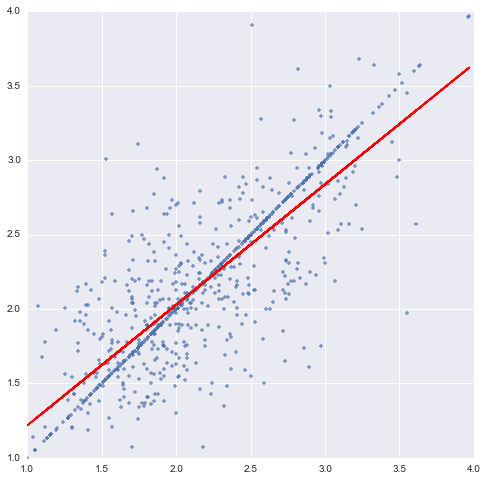

In [20]:
filt = auto_delta.automation_9.notnull()

x = auto_delta.automation_9[filt]
y = auto_delta.automation_15[filt]
m, b = np.polyfit(x, y, 1)

sns.plt.figure(figsize=(8,8))
sns.plt.plot(x, y, '.', alpha = 0.7)
sns.plt.plot(x, m*x + b, color = 'r')

> ### Note – best fit line shows that those with higher automation in 2009 had lower in 2015

### Mean analysis – most automated by mean of automation

In [21]:
print tt15.groupby('major_title')['automation_15'].mean().order(ascending = False)[:5]
print "\n"
print tt15.groupby('major_title')['automation_15'].mean().order(ascending = True)[:5]


major_title
Business and Financial Operations Occupations    2.678563
Office and Administrative Support Occupations    2.651893
Legal Occupations                                2.534961
Production Occupations                           2.459347
Computer and Mathematical Occupations            2.301344
Name: automation_15, dtype: float64


major_title
Education, Training, and Library Occupations                  1.740324
Installation, Maintenance, and Repair Occupations             1.795233
Personal Care and Service Occupations                         1.820787
Arts, Design, Entertainment, Sports, and Media Occupations    1.825710
Food Preparation and Serving Related Occupations              1.879812
Name: automation_15, dtype: float64


> The least automated in 2015 also seem like the most automatable

### Delta analysis – became the most automated

In [22]:
delta_analysis = became_automated.merge(occ_ref[['O*NET-SOC Code', 'Title']], how = 'left', on = 'O*NET-SOC Code')

In [23]:
print delta_analysis.groupby('Title')['delta_pct'].mean().order(ascending = False)[:5]
print "\n"
print delta_analysis.groupby('Title')['delta_pct'].mean().order(ascending = True)[:5]

Title
Stock Clerks- Stockroom, Warehouse, or Storage Yard    0.967320
Biologists                                             0.887850
Gaming Change Persons and Booth Cashiers               0.787356
Boilermakers                                           0.681529
Clergy                                                 0.608000
Name: delta_pct, dtype: float64


Title
Manicurists and Pedicurists                       -0.509174
Aviation Inspectors                               -0.445070
Forensic Science Technicians                      -0.442907
Forest and Conservation Workers                   -0.420849
Nursing Instructors and Teachers, Postsecondary   -0.418103
Name: delta_pct, dtype: float64


> "Clergy" increased heavily in automation. Love it – "Deus Ex Machina"

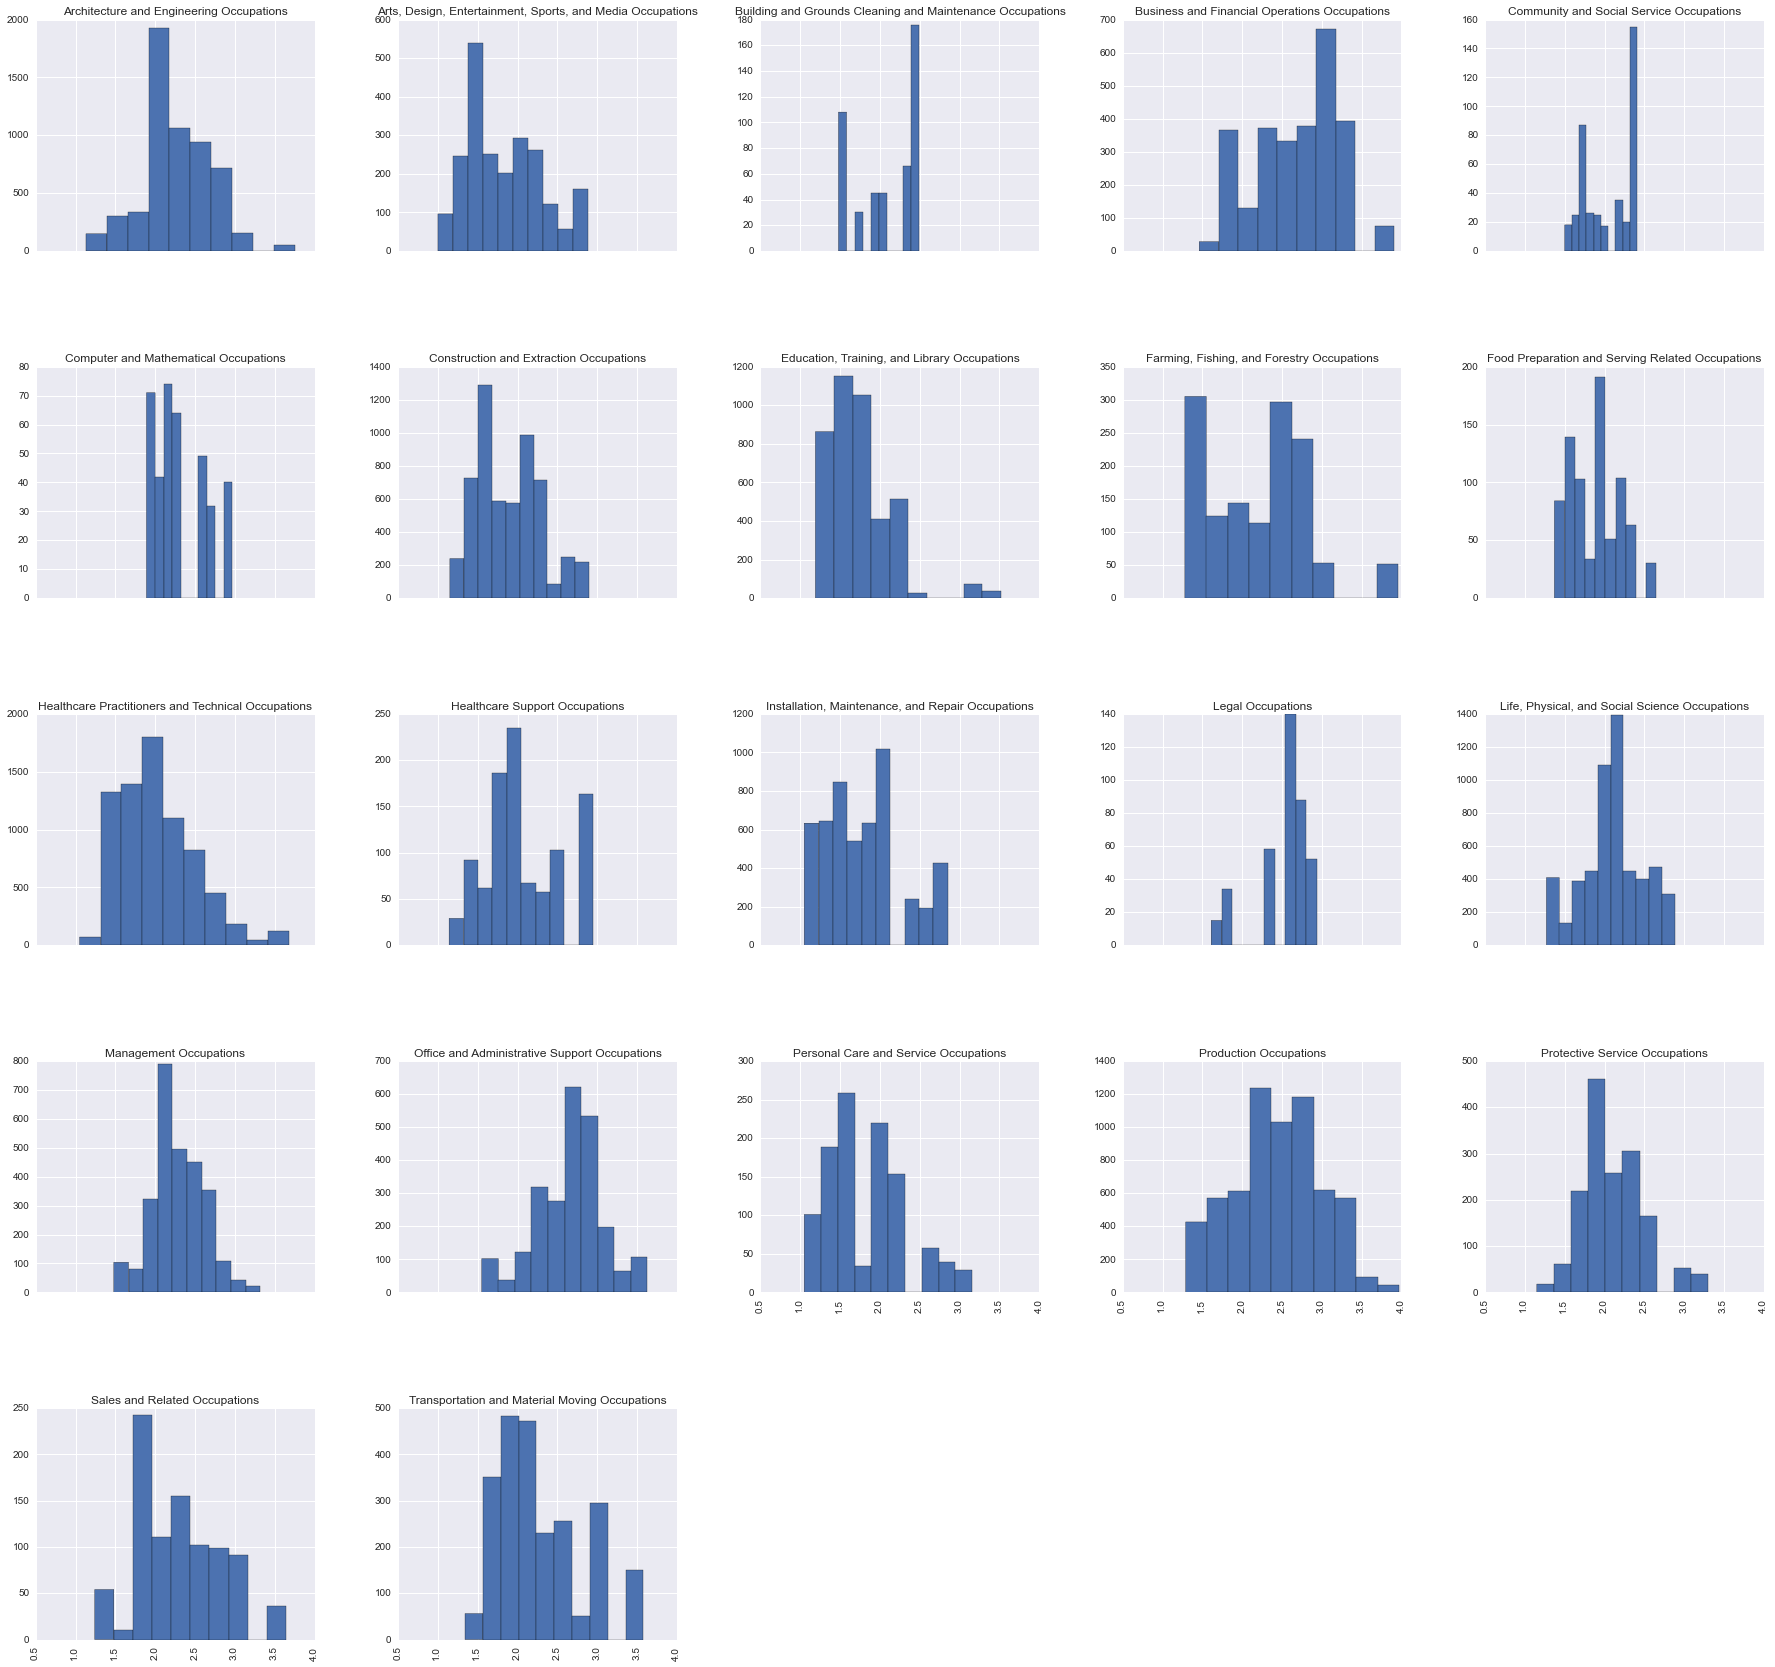

In [24]:
tt15['automation_15'].hist(by=tt15['major_title'], sharex = True, figsize=(30,30))
sns.plt.savefig('automation_histograms.png')
sns.plt.show()

In [25]:
for col in X.columns:
    sns.plt.scatter(np.array(X[col]), y)
    sns.plt.show()

NameError: name 'X' is not defined

# \# of TECHNOLOGIES ADOPTED

In [26]:
def return_new_technologies(new, old):
    occupations = set(new['O*NET-SOC Code'])
    adopted_df = pd.DataFrame(columns = new.columns)
    for occ in occupations:
        new_tech = set(new[new['O*NET-SOC Code'] == occ]['Commodity Code'])
        old_tech = set(old[old['O*NET-SOC Code'] == occ]['Commodity Code'])
        adopted = new_tech - old_tech
        adopted_df = adopted_df.append(new[(new['O*NET-SOC Code'] == occ) & (new['Commodity Code'].isin(adopted))])
    return adopted_df

In [27]:
adopted = return_new_technologies(tt15, tt9)

In [31]:
adopted.drop('automation_15', axis = 1).to_csv('tech_adoptions.csv', index=False)

In [ ]:
### num_per_occ = pd.DataFrame(np.log(adopted.groupby('O*NET-SOC Code')['Commodity Code'].count()))
num_per_occ['O*NET-SOC Code'] = num_per_occ.index
num_per_occ.columns = ['log_num_tech', 'O*NET-SOC Code']

# \# of TECHNOLOGIES REGRESSION

In [29]:
num_per_occ.head()

,log_num_tech,O*NET-SOC Code
O*NET-SOC Code,,
11-1011.00,0.000000,11-1011.00
11-1011.03,0.693147,11-1011.03
11-1021.00,3.178054,11-1021.00
11-1031.00,3.610918,11-1031.00
11-2011.00,1.791759,11-2011.00


In [482]:
X = create_factor_df('../data/db09/Skills.txt', 'LV')
X = X.merge(num_per_occ, how = 'left', on = 'O*NET-SOC Code').drop('O*NET-SOC Code', axis = 1)

In [483]:
y = X.log_num_tech
X = X.drop('log_num_tech', axis = 1)
filt = y.notnull()
y = y[filt]
X = X[filt]

In [484]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
rf = RandomForestRegressor(n_estimators = 1000)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

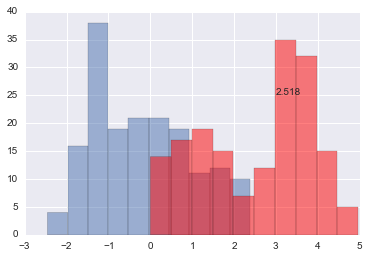

In [485]:
error = rf.predict(X_test) - y_test
mean = y_test.mean()
error.hist(alpha = 0.5)
y_test.hist(alpha = 0.5, color = 'r')
sns.plt.text(3, 25, str(round(mean, 3)))
sns.plt.show()

In [486]:
mse = np.mean(error**2)
rmse = np.sqrt(mse)
mean, rmse

(2.5176592413608683, 1.1753405479723344)

In [487]:
rf.score(X_test, y_test)

0.26737000191438431

## Gaussian Process

In [495]:
best_rmse = float('inf')
best_name = None
best_preds = None
nowork = []
for kernel in kern_list:
    try:
        m = GPy.models.GPRegression(np.array(X_train), np.array(y_train), kern)
        m.optimize(max_f_eval = 1000)
        mean, var = m.predict(np.array(X_test))
        rmse = get_rmse(mean.squeeze(), np.array(y_test))
        if rmse < best_rmse:
            best_rmse = rmse
            best_name = kern.name
            best_preds = mean.squeeze()
    except:
        nowork.append(kern.name)
    
    print kern.name, rmse

sum 1.17534054797
sum 1.17534054797
sum 1.17534054797
sum 1.17534054797
sum 1.17534054797
sum 1.17534054797
sum 1.17534054797
sum 1.17534054797
sum 1.17534054797
sum 1.17534054797
sum 1.17534054797
sum 1.17534054797
sum 1.17534054797


# PRIMITIVE FEATURE SELECTION

In [124]:
# mutual information
# variance

In [145]:
#std as a % of mean
std_per_mean = (np.std(X))/np.mean(X)
std_per_mean.sort()
std_per_mean

#std ranking
std = np.std(X)
std.sort()
std[:5]

Element Name
Learning Strategies    0.824000
Active Listening       0.877763
Coordination           0.879366
Time Management        0.893382
Programming            0.894594
dtype: float64

In [146]:
std_per_mean[:5]

Element Name
Learning Strategies    0.207807
Active Listening       0.209060
Coordination           0.214954
Critical Thinking      0.219874
Instructing            0.228290
dtype: float64

In [147]:
import math
import scipy
from scipy.stats import gaussian_kde
from scipy.integrate import dblquad

def mutual_information(x, y):
    # Constants
    MIN_DOUBLE = 4.9406564584124654e-324 
                        # The minimum size of a Float64; used here to prevent the
                        #  logarithmic function from hitting its undefined region
                        #  at its asymptote of 0.
    INF = float('inf')  # The floating-point representation for "infinity"

    # x and y are previously defined as collections of 
    # floating point values with the same length

    # Kernel estimation
    gkde_x = gaussian_kde(x)
    gkde_y = gaussian_kde(y)

    gkde_xy = gaussian_kde([x,y])
    mutual_info = lambda a,b: gkde_xy([a,b]) * \
        math.log((gkde_xy([a,b]) / ((gkde_x(a) * gkde_y(b)) + MIN_DOUBLE)) \
            + MIN_DOUBLE)
        
    # Compute MI(X,Y)
    (minfo_xy, err_xy) = \
        dblquad(mutual_info, -INF, INF, lambda a: 0, lambda a: INF)

    return minfo_xy

# Using Tasks

In [164]:
def create_task_df(path, scale_id):
    X = pd.read_table(path)
    X = X[X['Scale ID'] == scale_id][['O*NET-SOC Code', 'Task ID', 'Data Value', 'Category']]
    return X

In [221]:
task_X = create_task_df('../data/db09/Task Ratings.txt', 'FT')
task_X['val'] = task_X['Data Value']*task_X['Category'].astype('int')
task_X = pd.DataFrame(task_X.groupby(['O*NET-SOC Code', 'Task ID'])['val'].sum()/100).reset_index()
task_X = task_X.pivot(index = 'O*NET-SOC Code', columns = 'Task ID', values = 'val')

In [230]:
s = task_X.isnull().sum(axis = 1)/task_X.shape[1]
s2 = task_X.isnull().sum(axis = 0)/task_X.shape[0]

In [238]:
min(s), min(s2)

(0.99745773484174405, 0.99879663056558365)

In [258]:
print "SAMPLE OF TASK DESCRIPTIONS \n---------------------------\n"
for k, i in enumerate(pd.read_table('../data/db15/Task Statements.txt').Task[:5]):
    print k,": ", i + "\n"

SAMPLE OF TASK DESCRIPTIONS 
---------------------------

0 :  Direct or coordinate an organization's financial or budget activities to fund operations, maximize investments, or increase efficiency.

1 :  Appoint department heads or managers and assign or delegate responsibilities to them.

2 :  Analyze operations to evaluate performance of a company or its staff in meeting objectives or to determine areas of potential cost reduction, program improvement, or policy change.

3 :  Direct, plan, or implement policies, objectives, or activities of organizations or businesses to ensure continuing operations, to maximize returns on investments, or to increase productivity.

4 :  Prepare budgets for approval, including those for funding or implementation of programs.



> ### Seems like complex NLP will be needed to detailed and useful analysis on tasks.